<a href="https://colab.research.google.com/github/Hoang-it/orhcid_classification/blob/main/MEFOC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# MEFOC is stand for Multistage Extraction Features for Ochid Classification
# @author : Nguyen Huu Hoang
# @date-start : 6-9-2021

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from google.colab import drive
from tensorflow import keras

In [5]:
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
train_dir = '/content/drive/MyDrive/KLTN/dataset/OCD_IEEE/train/train'
test_dir = '/content/drive/MyDrive/KLTN/dataset/OCD_IEEE/test (1)/test'

BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)
test_dataset = image_dataset_from_directory(test_dir,
                                            shuffle=True,
                                            batch_size=BATCH_SIZE,
                                            image_size=IMG_SIZE)

Found 2820 files belonging to 52 classes.
Found 739 files belonging to 52 classes.


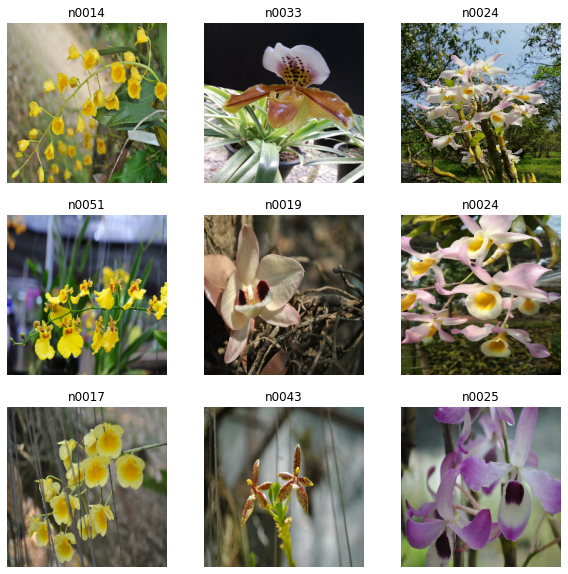

In [9]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [11]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [8]:
model_names = ['DenseNet121', 'DenseNet169', 'DenseNet201', 'EfficientNetB0', 'MobileNet', 'MobileNetV2' ]
models = {
    'DenseNet121': {
        'model': tf.keras.applications.DenseNet121(include_top=True, weights='imagenet', input_shape=(224, 224, 3)),
        'input_processing': tf.keras.applications.densenet.preprocess_input,
        'extract_layer': 'avg_pool',
    },
    'DenseNet169': {
        'model': tf.keras.applications.DenseNet169(include_top=True, weights='imagenet', input_shape=(224, 224, 3)),
        'input_processing': tf.keras.applications.densenet.preprocess_input,
        'extract_layer': 'avg_pool',
    },
    'DenseNet201': {
        'model': tf.keras.applications.DenseNet201(include_top=True, weights='imagenet', input_shape=(224, 224, 3)),
        'input_processing': tf.keras.applications.densenet.preprocess_input,
        'extract_layer': 'avg_pool',
    },
    'EfficientNetB0': {
        'model': tf.keras.applications.EfficientNetB0(include_top=True, weights='imagenet', input_shape=(224, 224, 3)),
        'input_processing': tf.keras.applications.efficientnet.preprocess_input,
        'extract_layer': 'avg_pool',
    },
    'MobileNet': {
        'model': tf.keras.applications.MobileNet(include_top=True, weights='imagenet', input_shape=(224, 224, 3)),
        'input_processing': tf.keras.applications.mobilenet.preprocess_input,
        'extract_layer': 'reshape_2',
    },
    'MobileNetV2': {
        'model': tf.keras.applications.MobileNetV2(include_top=True, weights='imagenet', input_shape=(224, 224, 3)),
        'input_processing': tf.keras.applications.mobilenet_v2.preprocess_input,
        'extract_layer': 'global_average_pooling2d_1',
    },
    
}

14548992/14536120 [==============================] - 0s 0us/step


In [12]:
def get_models(models, model_names, model_numbers):
  model_list = []
  for id in range(model_numbers):
    model_name = model_names[id]
    base_model = models[model_name]['model']
    layer_name = models[model_name]['extract_layer']
    preprocess_input = models[model_name]['input_processing']
    
    layer_extracted = keras.Model(inputs=base_model.input, outputs=base_model.get_layer(layer_name).output)
    inputs = base_model.input
    x = data_augmentation(inputs)
    x = preprocess_input(x)
    output = layer_extracted(x)
    model = keras.Model(inputs=inputs, outputs=output)
    model_list.append(model)
  return model_list

In [13]:
def features_extraction(dataset, models):
  x = []
  y = []
  for element in dataset: 
    image, label = element
    features = []
    for model in models:
      X = model(image)
      features.append(X)
    batch = []
    # print(len(features[0]))
    for index in range(len(image)):
      fms = ()
      features_concated = np.array([])
      for fm in features:
        # print(len(fm[index]))
        fms = fms + (fm[index], )
      # print(len(fms))
      features_concated = np.append(features_concated, np.concatenate(fms))
      batch.append(features_concated)
    # print(X.numpy())
    x.append(batch)
    y.append(label.numpy())
  data = []
  label = []
  for i in range(len(x)):
    for j in range(len(x[i])):
        # print(x_train[x][y])
        data.append(x[i][j])    
        label.append(y[i][j])
  return data, label

In [15]:
from sklearn import datasets, svm, metrics
from sklearn.svm import LinearSVC

model_len = []
accs = []
reports = []
for i in range(len(model_names)):
  X_train, y_train = features_extraction(train_dataset, get_models(models, model_names, model_numbers=i + 1))
  X_test, y_test = features_extraction(test_dataset, get_models(models, model_names, model_numbers=i + 1))

  clf = LinearSVC(C=1.0, max_iter=10000)
  clf.fit(X_train, y_train)

  accuracy = metrics.accuracy_score(y_test, clf.predict(X_test))
  model_len.append(i)
  accs.append(accuracy)
  reports.append(metrics.classification_report(y_test, clf.predict(X_test)))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
print(model_len)
print(accs)

[0, 1, 2, 3, 4, 5]
[0.8200270635994588, 0.8592692828146143, 0.8809201623815968, 0.8822733423545331, 0.8525033829499323, 0.8565629228687416]


In [19]:
from sklearn import datasets, svm, metrics
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

model_len_fs = []
accs_fs = []
reports_fs = []
for i in range(len(model_names)):
  X_train, y_train = features_extraction(train_dataset, get_models(models, model_names, model_numbers=i + 1))
  X_test, y_test = features_extraction(test_dataset, get_models(models, model_names, model_numbers=i + 1))

  clf = LinearSVC(C=1.0, max_iter=10000)
  clf.fit(X_train, y_train)

  model = SelectFromModel(clf, prefit=True)
  X_new = model.transform(X_train)
  test_new = model.transform(X_test)

  clf = LinearSVC(C=1.0, max_iter=10000)
  clf.fit(X_new, y_train)

  accuracy = metrics.accuracy_score(y_test, clf.predict(test_new))
  model_len_fs.append(i)
  accs_fs.append(accuracy)
  reports_fs.append(metrics.classification_report(y_test, clf.predict(test_new)))

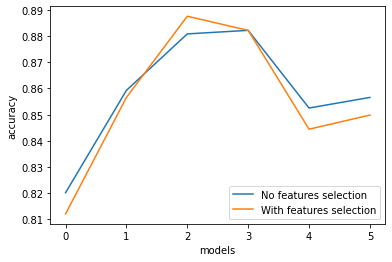

In [21]:
import matplotlib.pyplot as plt

plt.plot(model_len, accs, label = "No features selection")
plt.plot(model_len_fs, accs_fs, label = "With features selection")
plt.ylabel('accuracy')
plt.xlabel('models')
plt.legend()
plt.show()




In [ ]:

print(f"Classification report for classifier {clf}:\n"
      f"{reports[0]}\n")


In [ ]:
# References
@inproceedings{yolact-iccv2019,
  author    = {Daniel Bolya and Chong Zhou and Fanyi Xiao and Yong Jae Lee},
  title     = {YOLACT: {Real-time} Instance Segmentation},
  booktitle = {ICCV},
  year      = {2019},
}
@inproceedings{sarachai2019orchids,
  title        ={Orchids Classification Using Spatial Transformer Network with Adaptive Scaling},
  author       ={Sarachai, Watcharin and Bootkrajang, Jakramate and Chaijaruwanich, Jeerayut and Somhom, Samerkae},
  booktitle    ={International Conference on Intelligent Data Engineering and Automated Learning – IDEAL 2019},
  pages        ={1--10},
  DOI          ={978-3-030-33607-3_1},
  year         ={2019},
  organization ={Springer International Publishing}}

}
@data{DVN/0HNECY_2020,
  author    = {Apriyanti, D.H. and Spreeuwers, L.J. and Lucas, P.J.F. and Veldhuis, R.N.J.},
  publisher = {Harvard Dataverse},
  title     = {{Orchid Flowers Dataset}},
  year      = {2020},
  version   = {V1},
  doi       = {10.7910/DVN/0HNECY},
  url       = {https://doi.org/10.7910/DVN/0HNECY}
}